## Imports + Globals

In [230]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
import json
import os
import ast
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
API_KEY = os.environ['pga_api_key']

In [183]:
PROJECT_PATH = '/Users/huntermitchell/Documents/Documents/PYTHON_FILES/PGA_Winner_Prediction/v2'

CURRENT_YEAR = datetime.today().year
YEARS_BACK = 5

SEED = 2015

ALL_PLAYER_STATS_URL = "https://api.sportradar.us/golf/trial/pga/v2/en/{year}/players/statistics.json?api_key={api_key}"

PLAYER_STATS_URL = "https://api.sportradar.us/golf/trial/v3/en/players/{player_id}/profile.json?api_key={api_key}"

TOURNAMENTS_SCHEDULE_URL = "https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/schedule.json?api_key={api_key}"

TOURNAMENT_SUMMARY_URL = "https://api.sportradar.us/golf/trial/v3/en/{year}/tournaments/{tournament_id}/summary.json?api_key={api_key}"

TOURNAMENT_LEADERBOARD_URL = "https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/{tournament_id}/leaderboard.json?api_key={api_key}"

NEW_REQUEST_CURRENT_SEASON_STATS = False
NEW_REQUEST_TOURNAMENT_SCHEDULE = False
NEW_REQUEST_PREVIOUS_TOURNAMENTS = False

FEATURES = ['course_difficulty', 'gir_pct', 'putt_avg', 'scoring_avg', 'yardage/par*drive_avg', 'drive_acc*scrambling_pct',
    'strokes_gained_tee_green', 'strokes_gained_total', 'avg_temp', 'avg_wind_speed', 'rainy', 'sunny', 'cloudy']

LABELS = ['score']
TEST_SIZE = 0.1

FEATURES_TO_NOT_SCALE = ['rainy', 'sunny', 'cloudy']
FEATURES_TO_SCALE = [col for col in FEATURES if col not in FEATURES_TO_NOT_SCALE]

STATISTICS_FEATURES = ['drive_avg','drive_acc','gir_pct','putt_avg','strokes_gained','scrambling_pct','scoring_avg','strokes_gained_tee_green','strokes_gained_total']

In [4]:
PLAYER_NAMES = ['xander_schauffele','collin_morikawa','keegan_bradley','sungjae_im','rickie_fowler','hideki_matsuyama','sahith_theegala','cameron_davis','eric_cole']

NEXT_TOURNAMENT_CONDITION_INFO = {'avg_temp': 74, 'avg_wind_speed': 9, 'cloudy': 0, 'sunny': 1, 'rainy': 0}

## Functions

In [308]:
def get_player_info(player_name, current_season_stats_df):
    player_info = {}
    first_name = player_name.split('_')[0].title()
    last_name = player_name.split('_')[1].title()
    id = current_season_stats_df[(current_season_stats_df['first_name'] == first_name) & (current_season_stats_df['last_name'] == last_name)]['id'].values[0]
    player_info['first_name'] = first_name
    player_info['last_name'] = last_name
    player_info['id'] = id
    return player_info

def get_tournaments_schedule(url, year, new_request=False):
    print(f'Getting {year} tournaments schedule...')
    file_path = f'{PROJECT_PATH}/tournaments_schedule/{year}_tournaments.csv'
    if new_request:
        response = requests.get(url)
        df = pd.DataFrame(response.json()['tournaments'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def get_next_tournament(tournaments_schedule_df):
    return tournaments_schedule_df[tournaments_schedule_df['status']=='scheduled'].iloc[0]

def get_player_previous_tournaments_info(url, player_name, new_request=False):
    file_path = f'{PROJECT_PATH}/players_previous_tournaments/{player_name}.csv'
    if new_request:
        response = requests.get(url)
        df = pd.DataFrame(response.json()['previous_tournaments'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def get_current_season_stats_df(year, new_request=False):
    print(f'Getting this year season stats for player info lookup...')
    file_path = f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv'
    if new_request:
        response = requests.get(ALL_PLAYER_STATS_URL.format(year=year, api_key=API_KEY))
        df = pd.DataFrame(response.json()['players'])
        df.to_csv(file_path, index=False)
    else:
        df = pd.read_csv(file_path)
    return df

def backfill_all_player_season_stats(years_back = YEARS_BACK):
    print("Backfilling all player season stats...")
    for year in range(CURRENT_YEAR - years_back, CURRENT_YEAR + 1):
        file_path = f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv'
        if not os.path.isfile(file_path):
            time.sleep(3)
            response = requests.get(ALL_PLAYER_STATS_URL.format(year=year, api_key=API_KEY))
            df = pd.DataFrame(response.json()['players'])
            df.to_csv(file_path, index=False)

def backfill_tournament_summaries(tournament_ids):
    print("Backfilling tournament summaries of all previous tournaments for players we're predicting...")
    for tournament_id in tournament_ids:
        file_path = f'{PROJECT_PATH}/tournament_summaries/{tournament_id}.json'
        if not os.path.isfile(file_path):
            time.sleep(1)
            url = TOURNAMENT_SUMMARY_URL.format(year=CURRENT_YEAR,tournament_id=tournament_id,api_key=API_KEY)
            response = requests.get(url)
            with open(file_path, 'w') as fp:
                json.dump(response.json(), fp)

def generate_previous_tournaments_training_df(player_previous_tournaments_df):
    """
    Stroke play only, no playoffs, only PGA Tour, no TOUR Championship. Then filter to only last YEARS_BACK years
    """
    training_df = player_previous_tournaments_df[
        (player_previous_tournaments_df['event_type']=='stroke') & \
        (~player_previous_tournaments_df['name'].str.endswith('Playoff')) & \
        (player_previous_tournaments_df['name'] != "TOUR Championship")
        ][['id','name','first_name','last_name','seasons','leaderboard','start_date']]\
        .rename(columns={'id':'tournament_id','name':'tournament_name'})

    training_df['full_name'] = training_df['first_name'] + '_' + training_df['last_name']
    training_df['seasons'] = training_df['seasons'].apply(ast.literal_eval)
    training_df['leaderboard'] = training_df['leaderboard'].apply(ast.literal_eval)

    training_df = training_df.explode('seasons')

    training_df = training_df[training_df['seasons'].apply(lambda x: x['tour']['name']) == 'PGA Tour']

    training_df['season_id'] = training_df['seasons'].apply(lambda x: x['id'])
    training_df['score'] = training_df['leaderboard'].apply(lambda x: x['score'])
    training_df['start_date'] = pd.to_datetime(training_df['start_date'], format='%Y-%m-%d')

    training_df = training_df[training_df['start_date'] >= datetime(year=CURRENT_YEAR - YEARS_BACK,month=5,day=1)]
    training_df = training_df.drop(columns=['seasons','leaderboard','first_name','last_name']).reset_index(drop=True)

    return training_df

def get_course_difficulty_df():
    course_difficulty_df = pd.read_csv(f'{PROJECT_PATH}/course_difficulty_stats/dg_course_table.csv')[['course','adj_score_to_par']]
    return course_difficulty_df.rename(columns={'adj_score_to_par':'course_difficulty'})

def generate_season_stats_df(first_names, last_names):
    """
    Combine all season stats from "all_player_season_stats" folder
    """
    season_stats_df_list = []

    for year in range(CURRENT_YEAR-YEARS_BACK, CURRENT_YEAR+1):
        temp_df = pd.read_csv(f'{PROJECT_PATH}/all_player_season_stats/{year}_season_stats.csv')
        temp_df['year'] = year
        season_stats_df_list.append(temp_df)

    season_stats_df = pd.concat(season_stats_df_list)

    season_stats_df = season_stats_df[(season_stats_df['first_name'].isin(first_names)) & (season_stats_df['last_name'].isin(last_names))]
    season_stats_df['statistics'] = season_stats_df['statistics'].apply(ast.literal_eval)

    return season_stats_df

def generate_season_stats_training_df(season_stats_df, statistics_features):
    """
    Extract wanted features from "statistics" object column
    """
    for feature in statistics_features:
        season_stats_df[feature] = season_stats_df['statistics'].apply(lambda x: x[feature])
    
    season_stats_df['full_name'] = season_stats_df['first_name'] + '_' + season_stats_df['last_name']
    return season_stats_df.drop(columns=['id','country','statistics','first_name','last_name']).reset_index(drop=True)

def get_tournament_summary_training_df(tournament_ids):
    """
    Combine relevant course stats from "tournament_summaries" folder
    """
    tournament_summaries_data = []

    for tournament_id in tournament_ids:
        with open(f'{PROJECT_PATH}/tournament_summaries/{tournament_id}.json') as json_file:
            json_data = json.load(json_file)
            venue_data = json_data['venue']
            rounds_data = json_data['rounds']
            tournament_data = [tournament_id,
                            venue_data['name'],
                            venue_data['courses'][0]['yardage'],
                            venue_data['courses'][0]['par'],
                            [round_data['weather']['temp'] for round_data in rounds_data if 'weather' in round_data],
                            [round_data['weather']['condition'] for round_data in rounds_data if 'weather' in round_data],
                            [round_data['weather']['wind']['speed'] for round_data in rounds_data if 'weather' in round_data]
                            ]
            tournament_summaries_data.append(tournament_data)

    return pd.DataFrame(data=tournament_summaries_data, columns=['tournament_id','course','yardage','par','temps','conditions','wind_speeds'])

def combine_training_data(previous_tournaments_training_df, season_stats_training_df, tournament_summary_training_df, course_difficulty_df):
    training_df = previous_tournaments_training_df.merge(tournament_summary_training_df, how='left', on='tournament_id')
    training_df['year'] = training_df['start_date'].apply(lambda x: x.year if x.month >=3 else x.year-1) # if tourney is before March, we use last season stats
    training_df = training_df.merge(season_stats_training_df, how='left', on=['full_name','year'])
    return training_df.merge(course_difficulty_df, how='left',on='course')

def condition_mapping(condition):
    if 'rain' in condition or 'shower' in condition: return 'rainy'
    elif 'cloudy' in condition or condition == 'overcast': return 'cloudy'
    elif condition in ['clear','sunny']: return 'sunny'

def categorize_course_difficulty(difficulty):
    if difficulty >= 0.5:
        return 'hard'
    elif difficulty <= -0.5:
        return 'easy'
    else: return 'average'

def categorize_wind(wind):
    if wind >= 11.0:
        return 'windy'
    elif wind <= 7.0:
        return 'calm'
    else: return 'average'

def categorize_temp(temp):
    if temp >= 81.0:
        return 'hot'
    elif temp <= 68.0:
        return 'cold'
    else: return 'average'

def add_past_performance_features(df, features):
    for feature in features:
        df = df.sort_values(by=['full_name', feature, 'start_date'])
        df[f'past_performance_{feature}'] = df.groupby(['full_name', feature])['score'].expanding().mean().reset_index(drop=True)
    return df

def condition_one_hot_encode(conditions, condition_category):
    if len([condition for condition in conditions if condition == condition_category]) >= 2:
        return 1
    else:
        return 0

def engineer_features(training_df):
    # we get rid of rows with less than 3 days value of course conditions
    training_df = training_df[(training_df['temps'].str.len() >= 3) & (training_df['conditions'].str.len() >= 3) & (training_df['wind_speeds'].str.len() >= 3)]
    # we don't have season stats data for some players from 5+ years ago, so drop rows with nulls in those columns
    training_df = training_df.dropna(subset=STATISTICS_FEATURES)

    training_df['yardage/par'] = training_df['yardage']/training_df['par']
    training_df['avg_temp'] = training_df['temps'].apply(lambda x: round(sum(x) / len(x)))
    training_df['avg_wind_speed'] = training_df['wind_speeds'].apply(lambda x: round(sum(x) / len(x)))

    training_df['conditions_mapped'] = training_df['conditions'].apply(lambda conditions: [condition_mapping(condition.lower()) for condition in conditions])

    training_df['yardage/par*drive_avg'] = training_df['yardage/par'] * training_df['drive_avg']
    training_df['drive_acc*scrambling_pct'] = training_df['drive_acc'] * training_df['scrambling_pct']

    # fill course_difficulty null values with column mean
    training_df['course_difficulty'] = training_df['course_difficulty'].fillna(0.0)

    # we do 3 one-hot categories: Cloudy, Sunny, and Rain.
    condition_categories = ['cloudy', 'sunny','rainy']

    for condition_category in condition_categories:
        training_df[condition_category] = training_df['conditions_mapped'].apply(lambda conditions: condition_one_hot_encode(conditions, condition_category))

    return training_df.drop(columns=['yardage','par','temps','conditions','wind_speeds','conditions_mapped'])

def plot(x_label, y_label, df):
    plt.figure(figsize=(5,5))

    x = df[x_label].values
    y = df[y_label].values
    plt.scatter(x, y)

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x+b)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

def get_score(model, x_train_scaled, y_train):
  cv_score = cross_val_score(model, x_train_scaled, y_train, scoring="neg_root_mean_squared_error", cv = 8)
  rmse = -cv_score
  avg_rmse = round(np.mean(rmse), 5)
  std_dev_rmse = round(rmse.std(), 5)
  print('Cross-Validation Root Mean Squared Error:', rmse)
  print('Average Root Mean Squared Error:', avg_rmse)
  print('Standard deviation:', std_dev_rmse)
  return [avg_rmse, std_dev_rmse]

def get_results(preds, y_test):
  score = round(np.sqrt(mean_squared_error(preds,y_test.values)),5)
  print(f"Final RMSE: {score}")
  return score

def grid_search(model,params, x_train, y_train):
  search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error')
  search.fit(x_train,y_train)
  return search.best_estimator_

def get_next_tournament_course_difficulty(course_difficulty_df, course):
    try:
        return course_difficulty_df[course_difficulty_df['course']==course]['course_difficulty'].values[0]
    except IndexError:
        print('Course difficulty not available. Setting to 0.0')
        return 0.0

def generate_pred_df(season_stats_df, next_tournament_course_info, next_tournament_course_difficulty, next_tournament_condition_info):
    df = season_stats_df[season_stats_df['year']==CURRENT_YEAR]
    df['course_difficulty'] = next_tournament_course_difficulty
    df['yardage/par*drive_avg'] = next_tournament_course_info['yardage'] / next_tournament_course_info['par'] * df['drive_avg']
    df['drive_acc*scrambling_pct'] = df['drive_acc'] * df['scrambling_pct']
    for i in next_tournament_condition_info.items():
        df[i[0]] = i[1]
    
    return df.reset_index(drop=True)

## Setup

In [6]:
current_season_stats_df = get_current_season_stats_df(CURRENT_YEAR, new_request=NEW_REQUEST_CURRENT_SEASON_STATS)

Getting this year season stats for player info lookup...


In [7]:
players = {player: get_player_info(player, current_season_stats_df) for player in PLAYER_NAMES}
player_first_names = [info['first_name'] for _,info in players.items()]
player_last_names = [info['last_name'] for _,info in players.items()]

In [8]:
print(players)

{'xander_schauffele': {'first_name': 'Xander', 'last_name': 'Schauffele', 'id': '26dc0bda-b9a8-4303-9c1c-ddecda3817d2'}, 'collin_morikawa': {'first_name': 'Collin', 'last_name': 'Morikawa', 'id': 'f0ff1391-fc29-41bf-b46a-cd5ef9f63ad9'}, 'keegan_bradley': {'first_name': 'Keegan', 'last_name': 'Bradley', 'id': '0b5d3fd6-e3ec-4efd-8743-60db44c87425'}, 'sungjae_im': {'first_name': 'Sungjae', 'last_name': 'Im', 'id': 'ac1db384-8cb4-4223-bc46-60f4ed963645'}, 'rickie_fowler': {'first_name': 'Rickie', 'last_name': 'Fowler', 'id': '5735703a-32d9-4a6c-8b24-6596f300bc44'}, 'hideki_matsuyama': {'first_name': 'Hideki', 'last_name': 'Matsuyama', 'id': 'd45bcf4a-5803-4b0b-ab6c-6427a76cecf7'}, 'sahith_theegala': {'first_name': 'Sahith', 'last_name': 'Theegala', 'id': '25faf9c2-3b45-4630-aac8-d11229cde0a1'}, 'cameron_davis': {'first_name': 'Cameron', 'last_name': 'Davis', 'id': 'f2bc6b83-fab1-4567-8bcf-9287d1940f2d'}, 'eric_cole': {'first_name': 'Eric', 'last_name': 'Cole', 'id': 'c01c741a-fd91-4e1c-8d

In [9]:
tournaments_schedule_df = get_tournaments_schedule(url=TOURNAMENTS_SCHEDULE_URL.format(year=CURRENT_YEAR,api_key=API_KEY),
                                                   year=CURRENT_YEAR, new_request=NEW_REQUEST_TOURNAMENT_SCHEDULE)

Getting 2023 tournaments schedule...


In [10]:
next_tournament = get_next_tournament(tournaments_schedule_df)
print(next_tournament)

id                                231bafc7-b92c-49f8-ab5a-f3c705ae33b8
name                                                 ZOZO CHAMPIONSHIP
event_type                                                      stroke
purse                                                        8500000.0
winning_share                                                      NaN
currency                                                           USD
points                                                             NaN
start_date                                                  2023-10-19
end_date                                                    2023-10-22
course_timezone                                             Asia/Tokyo
network                                                            NaN
total_rounds                                                       NaN
status                                                       scheduled
cutline                                                            NaN
projec

## Generate Training Data

In [11]:
player_previous_tournaments_dfs = []

for player in players.keys():
    if NEW_REQUEST_PREVIOUS_TOURNAMENTS: time.sleep(1)
    temp_df = get_player_previous_tournaments_info(PLAYER_STATS_URL.format(player_id=players[player]['id'],api_key=API_KEY),
                                                                            player,
                                                                            new_request=NEW_REQUEST_PREVIOUS_TOURNAMENTS)
    temp_df['first_name'] = players[player]['first_name']
    temp_df['last_name'] = players[player]['last_name']
    player_previous_tournaments_dfs.append(temp_df)

player_previous_tournaments_df = pd.concat(player_previous_tournaments_dfs)

In [12]:
player_previous_tournaments_df.head()

id  \
0  24a5a75b-c60e-4029-befb-caaec2f52d31   
1  7c169ad4-434a-4231-88c8-778ecdf52283   
2  e1a1f28c-f025-489c-ad7a-f67f20ebc72a   
3  27816bd4-51c7-4697-843a-ea7622db2487   
4  74c1dfd9-635a-4b59-88fc-f40e48e4532b   

                                              name event_type currency  \
0  World Golf Championships-HSBC Champions Playoff     stroke      USD   
1           Sentry Tournament of Champions Playoff     stroke      USD   
2  World Golf Championships-HSBC Champions Playoff     stroke      USD   
3                         Career Builder Challenge     stroke      USD   
4                           Farmers Insurance Open     stroke      USD   

       course_timezone coverage  status scoring_system  \
0        Asia/Shanghai     full  closed         stroke   
1     Pacific/Honolulu     full  closed         stroke   
2        Asia/Shanghai     full  closed         stroke   
3  America/Los_Angeles     full  closed         stroke   
4  America/Los_Angeles     full  closed         stroke   

                                             seasons  \
0  [{'id': '8cf42dd8-8a1e-4a8a-9137-dc6ac59cd63d'...   
1  [{'id': '83eb0a3a-dd69-40d3-a9ba-f49e398fdb61'...   
2  [{'id': '83eb0a3a-dd69-40d3-a9ba-f49e398fdb61'...   
3  [{'id': 'f7df115a-0ddd-4894-8e81-07e27f533067'...   
4  [{'id': 'f7df115a-0ddd-4894-8e81-07e27f533067'...   

                                         leaderboard  ...  points  start_date  \
0  {'position': 1, 'tied': False, 'score': -1, 's...  ...     NaN         NaN   
1  {'position': 3, 'tied': False, 'score': 0, 'st...  ...     NaN         NaN   
2  {'position': 2, 'tied': False, 'score': 0, 'st...  ...     NaN         NaN   
3  {'position': 92, 'tied': True, 'score': -6, 's...  ...   500.0  2016-01-21   
4  {'position': 143, 'tied': True, 'score': 7, 's...  ...   500.0  2016-01-28   

     end_date                network winning_share  cut_round  cutline  \
0         NaN                    NaN           NaN        NaN      NaN   
1         NaN                    NaN           NaN        NaN      NaN   
2         NaN                    NaN           NaN        NaN      NaN   
3  2016-01-24       The Golf Channel     1044000.0        NaN      NaN   
4  2016-01-31  The Golf Channel, CBS     1170000.0        NaN      NaN   

   projected_cutline  first_name   last_name  
0                NaN      Xander  Schauffele  
1                NaN      Xander  Schauffele  
2                NaN      Xander  Schauffele  
3                NaN      Xander  Schauffele  
4                NaN      Xander  Schauffele  

[5 rows x 21 columns]

In [13]:
backfill_all_player_season_stats(YEARS_BACK)

Backfilling all player season stats...


In [14]:
previous_tournaments_training_df = generate_previous_tournaments_training_df(player_previous_tournaments_df)

In [15]:
previous_tournaments_training_df

tournament_id  \
0    f1458ef8-6d57-4b9d-b35b-ae163c35bf63   
1    6ff392df-0da8-45df-9733-f8460fd6dc8f   
2    b3b52f97-3c5f-49f8-94ac-e2f03f5879f4   
3    579d7c64-2904-4ce6-b9b2-8998794278d1   
4    ebdd3311-2abf-434d-9b7e-00396078c279   
..                                    ...   
933  97540454-f4b7-41a6-9a0d-d3c5bcc09442   
934  62335a36-7fd7-41d7-a729-30ded11fcd9c   
935  8700aba2-5e41-44cf-9178-91a8a990fd4e   
936  11630794-9c9a-4b3d-b15f-ce85bad28315   
937  693585bf-7e97-4179-83d6-ee3c512d22cf   

                                     tournament_name start_date  \
0                           Wells Fargo Championship 2018-05-03   
1                          THE PLAYERS Championship  2018-05-10   
2                            Fort Worth Invitational 2018-05-24   
3    the Memorial Tournament presented by Nationwide 2018-05-31   
4                                          U.S. Open 2018-06-14   
..                                               ...        ...   
933                      FedEx St. Jude Championship 2023-08-10   
934                                 BMW Championship 2023-08-17   
935                            Fortinet Championship 2023-09-14   
936                     Sanderson Farms Championship 2023-10-05   
937                         Shriners Children's Open 2023-10-12   

             full_name                             season_id  score  
0    Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      7  
1    Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e    -14  
2    Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      4  
3    Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      2  
4    Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      6  
..                 ...                                   ...    ...  
933          Eric_Cole  ece9907c-6fe3-4944-8cb9-bb1033270259     -6  
934          Eric_Cole  ece9907c-6fe3-4944-8cb9-bb1033270259     -3  
935          Eric_Cole  ece9907c-6fe3-4944-8cb9-bb1033270259    -16  
936          Eric_Cole  ece9907c-6fe3-4944-8cb9-bb1033270259     -9  
937          Eric_Cole  ece9907c-6fe3-4944-8cb9-bb1033270259    -18  

[938 rows x 6 columns]

In [16]:
backfill_tournament_summaries(previous_tournaments_training_df['tournament_id'].unique())

Backfilling tournament summaries of all previous tournaments for players we're predicting...


In [17]:
season_stats_df = generate_season_stats_df(player_first_names, player_last_names)
print("Available features from season stats data: ",season_stats_df['statistics'].values[0])

Available features from season stats data:  {'events_played': 27, 'first_place': 0, 'second_place': 2, 'third_place': 2, 'top_10': 7, 'top_25': 12, 'cuts': 5, 'cuts_made': 22, 'withdrawals': 0, 'points': 581.0, 'points_rank': 15, 'earnings': 4047538.0, 'earnings_rank': 18, 'drive_avg': 304.6, 'drive_acc': 59.09, 'gir_pct': 65.79, 'putt_avg': 1.764, 'sand_saves_pct': 48.91, 'birdies_per_round': 3.81, 'holes_per_eagle': 239.1, 'world_rank': 18, 'strokes_gained': 0.125, 'hole_proximity_avg': '37\' 2"', 'scrambling_pct': 58.76, 'scoring_avg': 70.486, 'strokes_gained_tee_green': 0.386, 'strokes_gained_total': 0.511, 'total_driving': 155}


In [18]:
season_stats_training_df = generate_season_stats_training_df(season_stats_df, STATISTICS_FEATURES)

In [19]:
season_stats_training_df.head()

year  drive_avg  drive_acc  gir_pct  putt_avg  strokes_gained  \
0  2018      304.6      59.09    65.79     1.764           0.125   
1  2018      302.0      61.69    69.77     1.747           0.115   
2  2018      299.5      67.90    69.41     1.781          -0.355   
3  2018      300.6      64.47    69.84     1.740           0.303   
4  2019      295.9      65.45    67.61     1.736           0.323   

   scrambling_pct  scoring_avg  strokes_gained_tee_green  \
0           58.76       70.486                     0.386   
1           61.08       70.022                     1.028   
2           58.08       70.303                     1.231   
3           64.21       69.435                     0.947   
4           64.53       70.252                     0.700   

   strokes_gained_total          full_name  
0                 0.511  Xander_Schauffele  
1                 1.143   Hideki_Matsuyama  
2                 0.876     Keegan_Bradley  
3                 1.249      Rickie_Fowler  
4                 1.023         Sungjae_Im

In [20]:
tournament_summary_training_df = get_tournament_summary_training_df(previous_tournaments_training_df['tournament_id'].unique())

In [21]:
tournament_summary_training_df.head()

tournament_id                      course  yardage  \
0  f1458ef8-6d57-4b9d-b35b-ae163c35bf63           Quail Hollow Club     7554   
1  6ff392df-0da8-45df-9733-f8460fd6dc8f                TPC Sawgrass     7189   
2  b3b52f97-3c5f-49f8-94ac-e2f03f5879f4                 Colonial CC     7209   
3  579d7c64-2904-4ce6-b9b2-8998794278d1        Muirfield Village GC     7392   
4  ebdd3311-2abf-434d-9b7e-00396078c279  Shinnecock Hills Golf Club     7440   

   par             temps                                         conditions  \
0   71  [81, 82, 78, 80]  [Partly cloudy, Partly cloudy, Overcast, Partl...   
1   72  [79, 82, 83, 79]       [Partly cloudy, Partly cloudy, Sunny, Sunny]   
2   70  [88, 81, 95, 97]  [Partly cloudy, Partly cloudy, Sunny, Partly c...   
3   72  [87, 76, 78, 81]       [Sunny, Sunny, Partly cloudy, Partly cloudy]   
4   70  [59, 59, 57, 57]  [Clear, Clear, Light Drizzle And Rain, Light D...   

       wind_speeds  
0  [9, 11, 12, 12]  
1   [13, 7, 12, 8]  
2    [6, 11, 4, 7]  
3   [12, 4, 6, 16]  
4     [0, 0, 8, 8]

In [22]:
course_difficulty_df = get_course_difficulty_df()

In [23]:
course_difficulty_df.head()

course  course_difficulty
0                  St. Andrews              -0.29
1         Kiawah Island Resort               2.57
2         Trump National Doral               1.89
3  PGA National Resort and Spa               1.42
4        Eagle Point Golf Club               0.70

In [24]:
course_difficulty_courses = sorted(course_difficulty_df.course.unique())
#print("Courses with difficulty stats:\n",course_difficulty_courses)
training_data_courses = sorted(tournament_summary_training_df.course.unique())
#print("\n\nCourses in training data:\n",training_data_courses)

print('Courses in training data but not in course difficulty data:\n',sorted(set(training_data_courses)-set(course_difficulty_courses)))

Courses in training data but not in course difficulty data:
 ['Accordia Golf Narashino Country Club', 'Albany, The Bahamas', 'Carnoustie Golf Links', 'Coco Beach Golf and Country Club', 'El Camaleon GC at the Mayakoba Resort', 'Montreux Golf and Country Club', 'Nine Bridges Golf Club', 'Port Royal Golf Course', 'Puntacana Resort & Club', 'Royal Portrush Golf Club', "Royal St. George's Golf Club", 'Sheshan International GC', 'Shinnecock Hills Golf Club', 'Silverado Resort and Spa (North Course)', 'TPC Kuala Lumpur ', 'Tahoe Mountain Club', 'The Country Club of Brookline', 'The Greenbrier']


In [25]:
previous_tournaments_training_df.head()

tournament_id  \
0  f1458ef8-6d57-4b9d-b35b-ae163c35bf63   
1  6ff392df-0da8-45df-9733-f8460fd6dc8f   
2  b3b52f97-3c5f-49f8-94ac-e2f03f5879f4   
3  579d7c64-2904-4ce6-b9b2-8998794278d1   
4  ebdd3311-2abf-434d-9b7e-00396078c279   

                                   tournament_name start_date  \
0                         Wells Fargo Championship 2018-05-03   
1                        THE PLAYERS Championship  2018-05-10   
2                          Fort Worth Invitational 2018-05-24   
3  the Memorial Tournament presented by Nationwide 2018-05-31   
4                                        U.S. Open 2018-06-14   

           full_name                             season_id  score  
0  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      7  
1  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e    -14  
2  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      4  
3  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      2  
4  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      6

In [126]:
training_df = combine_training_data(previous_tournaments_training_df, season_stats_training_df, tournament_summary_training_df, course_difficulty_df)

In [85]:
training_df.head()

tournament_id  \
0  f1458ef8-6d57-4b9d-b35b-ae163c35bf63   
1  6ff392df-0da8-45df-9733-f8460fd6dc8f   
2  b3b52f97-3c5f-49f8-94ac-e2f03f5879f4   
3  579d7c64-2904-4ce6-b9b2-8998794278d1   
4  ebdd3311-2abf-434d-9b7e-00396078c279   

                                   tournament_name start_date  \
0                         Wells Fargo Championship 2018-05-03   
1                        THE PLAYERS Championship  2018-05-10   
2                          Fort Worth Invitational 2018-05-24   
3  the Memorial Tournament presented by Nationwide 2018-05-31   
4                                        U.S. Open 2018-06-14   

           full_name                             season_id  score  \
0  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      7   
1  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e    -14   
2  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      4   
3  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      2   
4  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      6   

                       course  yardage  par             temps  ... drive_avg  \
0           Quail Hollow Club     7554   71  [81, 82, 78, 80]  ...     304.6   
1                TPC Sawgrass     7189   72  [79, 82, 83, 79]  ...     304.6   
2                 Colonial CC     7209   70  [88, 81, 95, 97]  ...     304.6   
3        Muirfield Village GC     7392   72  [87, 76, 78, 81]  ...     304.6   
4  Shinnecock Hills Golf Club     7440   70  [59, 59, 57, 57]  ...     304.6   

  drive_acc  gir_pct  putt_avg  strokes_gained  scrambling_pct  scoring_avg  \
0     59.09    65.79     1.764           0.125           58.76       70.486   
1     59.09    65.79     1.764           0.125           58.76       70.486   
2     59.09    65.79     1.764           0.125           58.76       70.486   
3     59.09    65.79     1.764           0.125           58.76       70.486   
4     59.09    65.79     1.764           0.125           58.76       70.486   

   strokes_gained_tee_green  strokes_gained_total  course_difficulty  
0                     0.386                 0.511               0.86  
1                     0.386                 0.511               0.78  
2                     0.386                 0.511               0.60  
3                     0.386                 0.511               0.99  
4                     0.386                 0.511                NaN  

[5 rows x 23 columns]

In [400]:
#training_df['course'].value_counts().value_counts()
# in case we want to try course history or having course be a feature

In [28]:
training_df.columns

Index(['tournament_id', 'tournament_name', 'start_date', 'full_name',
       'season_id', 'score', 'course', 'yardage', 'par', 'temps', 'conditions',
       'wind_speeds', 'year', 'drive_avg', 'drive_acc', 'gir_pct', 'putt_avg',
       'strokes_gained', 'scrambling_pct', 'scoring_avg',
       'strokes_gained_tee_green', 'strokes_gained_total',
       'course_difficulty'],
      dtype='object')

In [127]:
training_df = training_df[['yardage','par','course_difficulty','temps','conditions','wind_speeds','drive_avg','drive_acc','gir_pct','putt_avg',\
                           'strokes_gained','scrambling_pct','scoring_avg','strokes_gained_tee_green','strokes_gained_total','score']]

## Feature Engineering

In [129]:
training_df.head()

yardage  par  course_difficulty             temps  \
0     7554   71               0.86  [81, 82, 78, 80]   
1     7189   72               0.78  [79, 82, 83, 79]   
2     7209   70               0.60  [88, 81, 95, 97]   
3     7392   72               0.99  [87, 76, 78, 81]   
4     7440   70                NaN  [59, 59, 57, 57]   

                                          conditions      wind_speeds  \
0  [Partly cloudy, Partly cloudy, Overcast, Partl...  [9, 11, 12, 12]   
1       [Partly cloudy, Partly cloudy, Sunny, Sunny]   [13, 7, 12, 8]   
2  [Partly cloudy, Partly cloudy, Sunny, Partly c...    [6, 11, 4, 7]   
3       [Sunny, Sunny, Partly cloudy, Partly cloudy]   [12, 4, 6, 16]   
4  [Clear, Clear, Light Drizzle And Rain, Light D...     [0, 0, 8, 8]   

   drive_avg  drive_acc  gir_pct  putt_avg  strokes_gained  scrambling_pct  \
0      304.6      59.09    65.79     1.764           0.125           58.76   
1      304.6      59.09    65.79     1.764           0.125           58.76   
2      304.6      59.09    65.79     1.764           0.125           58.76   
3      304.6      59.09    65.79     1.764           0.125           58.76   
4      304.6      59.09    65.79     1.764           0.125           58.76   

   scoring_avg  strokes_gained_tee_green  strokes_gained_total  score  
0       70.486                     0.386                 0.511      7  
1       70.486                     0.386                 0.511    -14  
2       70.486                     0.386                 0.511      4  
3       70.486                     0.386                 0.511      2  
4       70.486                     0.386                 0.511      6

In [130]:
training_df = engineer_features(training_df)

In [110]:
assert not (training_df['cloudy']+training_df['sunny']+training_df['rainy']).any() == 0, "training data contains one or more rows with no weather condition categories"
assert not training_df.isnull().values.any(), "training data contains one or more rows with null values"

In [31]:
#### NEW STUFF TESTING:
training_df.columns

Index(['tournament_id', 'tournament_name', 'start_date', 'full_name',
       'season_id', 'score', 'course', 'year', 'drive_avg', 'drive_acc',
       'gir_pct', 'putt_avg', 'strokes_gained', 'scrambling_pct',
       'scoring_avg', 'strokes_gained_tee_green', 'strokes_gained_total',
       'course_difficulty', 'yardage/par', 'avg_temp', 'avg_wind_speed',
       'cloudy', 'sunny', 'rainy'],
      dtype='object')

In [87]:
training_df.head()

tournament_id  \
0  f1458ef8-6d57-4b9d-b35b-ae163c35bf63   
1  6ff392df-0da8-45df-9733-f8460fd6dc8f   
2  b3b52f97-3c5f-49f8-94ac-e2f03f5879f4   
3  579d7c64-2904-4ce6-b9b2-8998794278d1   
4  ebdd3311-2abf-434d-9b7e-00396078c279   

                                   tournament_name start_date  \
0                         Wells Fargo Championship 2018-05-03   
1                        THE PLAYERS Championship  2018-05-10   
2                          Fort Worth Invitational 2018-05-24   
3  the Memorial Tournament presented by Nationwide 2018-05-31   
4                                        U.S. Open 2018-06-14   

           full_name                             season_id  score  \
0  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      7   
1  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e    -14   
2  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      4   
3  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      2   
4  Xander_Schauffele  dbc9bbb1-e51c-47bc-8f72-be7598ffbf7e      6   

                       course  year  drive_avg  drive_acc  ...  scoring_avg  \
0           Quail Hollow Club  2018      304.6      59.09  ...       70.486   
1                TPC Sawgrass  2018      304.6      59.09  ...       70.486   
2                 Colonial CC  2018      304.6      59.09  ...       70.486   
3        Muirfield Village GC  2018      304.6      59.09  ...       70.486   
4  Shinnecock Hills Golf Club  2018      304.6      59.09  ...       70.486   

   strokes_gained_tee_green  strokes_gained_total  course_difficulty  \
0                     0.386                 0.511               0.86   
1                     0.386                 0.511               0.78   
2                     0.386                 0.511               0.60   
3                     0.386                 0.511               0.99   
4                     0.386                 0.511               0.00   

   yardage/par  avg_temp  avg_wind_speed  cloudy  sunny  rainy  
0   106.394366        80              11       1      0      0  
1    99.847222        81              10       1      1      0  
2   102.985714        90               7       1      0      0  
3   102.666667        80              10       1      1      0  
4   106.285714        58               4       0      1      1  

[5 rows x 24 columns]

In [75]:
"""
Stuff I've tried for including player past performance in certain course conditions:
training_df['course_difficulty_cat'] = training_df['course_difficulty'].apply(lambda x: categorize_course_difficulty(x))
training_df['wind_cat'] = training_df['avg_wind_speed'].apply(lambda x: categorize_wind(x))
training_df['temp_cat'] = training_df['avg_temp'].apply(lambda x: categorize_temp(x))

For now I'm just trying their average score in certain conditions.
We will want to also try their difference between average score (or average overall player score) in certain conditions
training_df = add_past_performance_features(training_df, ['course_difficulty_cat','wind_cat','temp_cat','rainy'])

NOTE
The performance features don't seem to do much. I'm only going to work on the drive_distance + course_distance feature.
Then refine all other features to what's most important. Then experiment with different models.

Bad Feature combos I've tried:
training_df['putt_avg*gir_pct'] = training_df['putt_avg'] * training_df['gir_pct'] # eh
training_df['drive_acc*drive_avg'] = training_df['drive_acc'] * training_df['drive_avg'] # eh

Adding
- yardage/par*drive_avg
- drive_acc*scrambling_pct
and removing:
- drive_avg
- drive_acc
- strokes_gained
- scrambling_pct
Seemed to not do much difference to training set, but did improve the test set RMSE

Removing cloudy and sunny decreased model performance. Decided to keep those. Also removed yardage/par to keep yardage/par*drive_avg
"""

In [146]:
training_df.corr()['score'].sort_values(ascending=False)

score                       1.000000
course_difficulty           0.547263
yardage/par                 0.235184
yardage/par*drive_avg       0.219037
scoring_avg                 0.159843
avg_wind_speed              0.155708
rainy                       0.104573
putt_avg                    0.087121
sunny                       0.042478
drive_avg                   0.040610
cloudy                      0.029014
strokes_gained             -0.071147
drive_acc                  -0.084202
scrambling_pct             -0.124938
drive_acc*scrambling_pct   -0.134372
strokes_gained_tee_green   -0.145286
avg_temp                   -0.156136
gir_pct                    -0.160807
strokes_gained_total       -0.170830
Name: score, dtype: float64

In [98]:
training_df[['yardage/par','avg_wind_speed','putt_avg','drive_avg','strokes_gained','drive_acc','scrambling_pct','strokes_gained_tee_green','gir_pct','strokes_gained_total']].describe()

yardage/par  avg_wind_speed    putt_avg   drive_avg  strokes_gained  \
count   864.000000      864.000000  864.000000  864.000000      864.000000   
mean    103.015436        9.182870    1.747951  302.365278        0.039914   
std       2.400249        3.282579    0.021031    4.549282        0.320417   
min      94.666667        2.000000    1.698000  294.700000       -0.683000   
25%     101.731221        7.000000    1.736000  298.300000       -0.119000   
50%     103.305556        9.000000    1.746000  303.000000        0.067000   
75%     104.514286       11.000000    1.760000  305.400000        0.292000   
max     109.388889       18.000000    1.793000  310.900000        0.668000   

        drive_acc  scrambling_pct  strokes_gained_tee_green     gir_pct  \
count  864.000000      864.000000                864.000000  864.000000   
mean    61.522442       60.927396                  0.846911   67.885000   
std      4.546440        2.649581                  0.403799    2.042753   
min     53.010000       55.720000                  0.092000   62.210000   
25%     58.820000       59.140000                  0.493000   66.470000   
50%     60.730000       60.770000                  0.865000   68.290000   
75%     65.270000       63.050000                  1.227000   69.380000   
max     72.100000       66.490000                  1.547000   71.880000   

       strokes_gained_total  
count            864.000000  
mean               0.886765  
std                0.476881  
min               -0.162000  
25%                0.555500  
50%                0.976000  
75%                1.231000  
max                1.869000

## Analysis

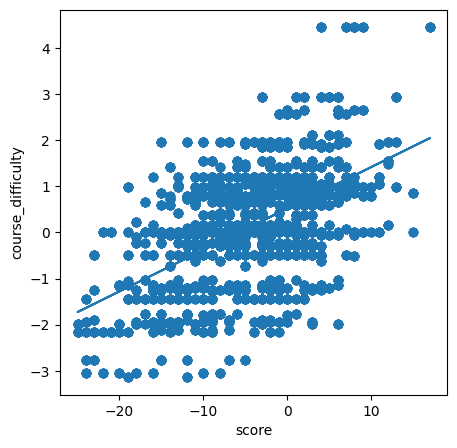

In [495]:
plot('score','course_difficulty',training_df)

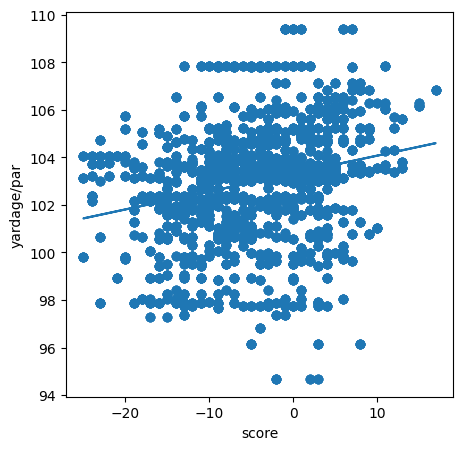

In [496]:
plot('score','yardage/par',training_df)

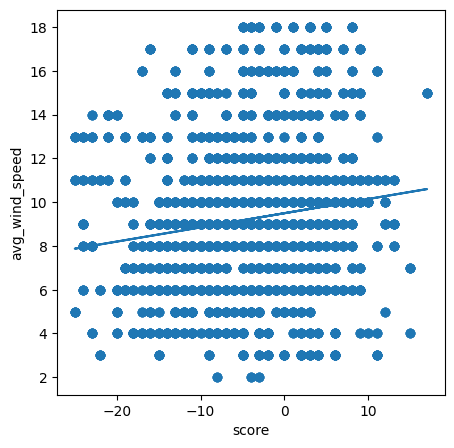

In [497]:
plot('score','avg_wind_speed',training_df)

In [498]:
plot('score','avg_temp',training_df)

In [132]:
training_df.corr()['score'].sort_values(ascending=False)

score                       1.000000
course_difficulty           0.547263
yardage/par                 0.235184
yardage/par*drive_avg       0.219037
scoring_avg                 0.159843
avg_wind_speed              0.155708
rainy                       0.104573
putt_avg                    0.087121
sunny                       0.042478
drive_avg                   0.040610
cloudy                      0.029014
strokes_gained             -0.071147
drive_acc                  -0.084202
scrambling_pct             -0.124938
drive_acc*scrambling_pct   -0.134372
strokes_gained_tee_green   -0.145286
avg_temp                   -0.156136
gir_pct                    -0.160807
strokes_gained_total       -0.170830
Name: score, dtype: float64

In [486]:
training_df.describe()

course_difficulty    drive_avg    drive_acc      gir_pct     putt_avg  \
count        6659.000000  6659.000000  6659.000000  6659.000000  6659.000000   
mean            0.107423   302.518141    61.437075    67.899638     1.746697   
std             1.263247     4.606025     4.568950     2.117068     0.020892   
min            -3.140000   294.700000    53.010000    62.210000     1.699000   
25%            -0.490000   298.200000    58.820000    66.470000     1.734000   
50%             0.100000   303.100000    60.620000    68.290000     1.745000   
75%             0.990000   307.500000    65.030000    69.380000     1.758000   
max             4.450000   310.200000    72.100000    71.880000     1.793000   

       strokes_gained  scrambling_pct  scoring_avg  strokes_gained_tee_green  \
count     6659.000000     6659.000000  6659.000000               6659.000000   
mean         0.045831       60.868734    70.176487                  0.867760   
std          0.325936        2.641533     0.511540                  0.410571   
min         -0.683000       55.720000    69.083000                  0.092000   
25%         -0.119000       59.140000    69.841000                  0.493000   
50%          0.067000       60.740000    70.116000                  0.986000   
75%          0.303000       63.050000    70.563000                  1.227000   
max          0.668000       66.490000    71.330000                  1.547000   

       strokes_gained_total        score  yardage/par     avg_temp  \
count           6659.000000  6659.000000  6659.000000  6659.000000   
mean               0.913499    -4.573510   102.970463    74.290434   
std                0.486711     7.662809     2.462776     9.063478   
min               -0.162000   -25.000000    94.666667    44.000000   
25%                0.641000   -10.000000   101.591549    68.000000   
50%                0.976000    -4.000000   103.305556    75.000000   
75%                1.232000     1.000000   104.541667    82.000000   
max                1.869000    17.000000   109.388889    93.000000   

       avg_wind_speed       cloudy        sunny        rainy  
count     6659.000000  6659.000000  6659.000000  6659.000000  
mean         9.201832     0.649347     0.478450     0.031536  
std          3.298113     0.477210     0.499573     0.174775  
min          2.000000     0.000000     0.000000     0.000000  
25%          7.000000     0.000000     0.000000     0.000000  
50%          9.000000     1.000000     0.000000     0.000000  
75%         11.000000     1.000000     1.000000     0.000000  
max         18.000000     1.000000     1.000000     1.000000

## Split Data

In [413]:
training_df.columns

Index(['course_difficulty', 'drive_avg', 'drive_acc', 'gir_pct', 'putt_avg',
       'strokes_gained', 'scrambling_pct', 'scoring_avg',
       'strokes_gained_tee_green', 'strokes_gained_total', 'score',
       'yardage/par', 'avg_temp', 'avg_wind_speed', 'cloudy', 'sunny',
       'rainy'],
      dtype='object')

In [184]:
features_df = training_df[FEATURES]
labels_df = training_df[LABELS]

# split data into 90% training and 10% testing
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=TEST_SIZE)

## Preprocessing

In [185]:
scaler = StandardScaler()

In [186]:
x_train_scaled = pd.concat(
    [pd.DataFrame(scaler.fit_transform(x_train[FEATURES_TO_SCALE]), index=x_train.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(x_train[FEATURES_TO_NOT_SCALE], index=x_train.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

x_test_scaled = pd.concat(
    [pd.DataFrame(scaler.transform(x_test[FEATURES_TO_SCALE]), index=x_test.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(x_test[FEATURES_TO_NOT_SCALE], index=x_test.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

In [187]:
#x_train_scaled.head()
x_test_scaled.head()

course_difficulty   gir_pct  putt_avg  scoring_avg  \
575           2.260383  0.128415 -1.546247    -1.397197   
419          -1.280743  0.601999 -0.086825     0.135914   
17           -1.870930 -1.021014  0.760582     0.540402   
700           0.683854 -0.389568  0.101488    -0.114672   
193           1.427652  1.475170  0.054409    -1.191993   

     yardage/par*drive_avg  drive_acc*scrambling_pct  \
575               1.546547                 -0.306280   
419              -0.434212                  1.580931   
17                0.234625                 -0.843367   
700               0.014417                  0.501506   
193               0.098252                  1.279666   

     strokes_gained_tee_green  strokes_gained_total  avg_temp  avg_wind_speed  \
575                  0.731929              1.143031 -1.395439       -0.071504   
419                 -0.389447              0.199959  0.747137       -0.982299   
17                  -1.128761             -0.774549  0.296068        1.446488   
700                  0.444142              0.044876  1.423740       -0.982299   
193                  1.751588              1.168180 -0.718836       -1.893094   

     rainy  sunny  cloudy  
575      0      0       1  
419      0      0       1  
17       0      0       1  
700      0      1       0  
193      0      1       1

## Training

In [309]:
model_scores = {}

In [207]:
xgboost_model = XGBRegressor(random_state=SEED, objective='reg:squarederror')

In [208]:
xgboost_model.fit(x_train_scaled,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2015,
             reg_alpha=0, reg_lambda=1, ...)

In [310]:
model_scores['xgboost'] = get_score(xgboost_model, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.63263676 6.5111007  7.14786066 6.80370527 7.137238   7.31300405
 6.74968704 6.18299869]
Average Root Mean Squared Error: 6.80978
Standard deviation: 0.35211


In [238]:
xgboost_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2015,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [311]:
xgboost_param_grid = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2, 0.3],
        "max_depth": [5,6,7,8]
}

xgboost_model_grid = grid_search(xgboost_model, xgboost_param_grid, x_train_scaled, y_train)

model_scores['xgboost_grid_search'] = get_score(xgboost_model_grid, x_train_scaled, y_train)


Cross-Validation Root Mean Squared Error: [5.95597344 6.07342596 6.36075216 5.91301997 6.15327422 6.80504629
 6.60573296 5.77305605]
Average Root Mean Squared Error: 6.20504
Standard deviation: 0.33517


In [332]:
sorted_idx = np.argsort(xgboost_model_grid.feature_importances_)[::-1]

for index in sorted_idx:
    print([x_train_scaled.columns[index], xgboost_model_grid.feature_importances_[index]]) 

['course_difficulty', 0.2692376]
['strokes_gained_total', 0.11781109]
['scoring_avg', 0.07565283]
['avg_temp', 0.0689712]
['strokes_gained_tee_green', 0.06551765]
['rainy', 0.063479245]
['putt_avg', 0.058075313]
['avg_wind_speed', 0.05402805]
['yardage/par*drive_avg', 0.051996507]
['drive_acc*scrambling_pct', 0.050124396]
['gir_pct', 0.0459857]
['cloudy', 0.042249378]
['sunny', 0.036870964]


In [312]:
linreg_model = LinearRegression()

linreg_model.fit(x_train_scaled,y_train)

model_scores['linear_regression'] = get_score(linreg_model, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.12609601 6.2038344  6.51144402 5.63652952 6.0859961  6.50397036
 6.56570684 5.75201226]
Average Root Mean Squared Error: 6.1732
Standard deviation: 0.32674


In [313]:
ridge_model = Ridge(random_state=SEED)

ridge_model.fit(x_train_scaled,y_train)

model_scores['ridge_regression'] = get_score(ridge_model, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.12255264 6.20650845 6.50149562 5.63090329 6.08420408 6.50653091
 6.57256145 5.75043324]
Average Root Mean Squared Error: 6.1719
Standard deviation: 0.3284


In [233]:
ridge_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': 2015,
 'solver': 'auto',
 'tol': 0.001}

In [314]:
ridge_param_grid = {
        "alpha": [0.01, 0.1, 1.0, 10.0]
}

ridge_model_grid = grid_search(ridge_model, ridge_param_grid, x_train_scaled, y_train)

model_scores['ridge_regression_grid_search'] = get_score(ridge_model_grid, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.10373055 6.22541188 6.45633441 5.60328174 6.07529774 6.52076414
 6.60960098 5.743494  ]
Average Root Mean Squared Error: 6.16724
Standard deviation: 0.3387


In [315]:
lasso_model = Lasso(random_state=SEED)

lasso_model.fit(x_train_scaled,y_train)

model_scores['lasso_regression'] = get_score(lasso_model, x_train_scaled, y_train)

Cross-Validation Root Mean Squared Error: [6.46817358 6.5182945  6.61992236 5.86489546 6.06993026 6.64112945
 6.82096456 5.98824835]
Average Root Mean Squared Error: 6.37394
Standard deviation: 0.32821


In [249]:
lasso_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 2015,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [316]:
lasso_param_grid = {
        "alpha": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
        "fit_intercept": [True, False], 
        "normalize": [True, False],
        "tol": [0.0005,.0001,0.00005]
}

lasso_model_grid = grid_search(lasso_model, lasso_param_grid, x_train_scaled, y_train)

model_scores['lasso_regression_grid_search'] = get_score(lasso_model_grid, x_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardS

Cross-Validation Root Mean Squared Error: [6.12593827 6.24624067 6.40419451 5.57864474 6.06009515 6.62479334
 6.70105813 5.71856452]
Average Root Mean Squared Error: 6.18244
Standard deviation: 0.37346


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [317]:
svr_model = SVR()

svr_model.fit(x_train_scaled,y_train)

model_scores['support_vector_regressor'] = get_score(svr_model, x_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validati

Cross-Validation Root Mean Squared Error: [6.13684851 6.13504793 6.88223826 6.07368012 6.20535052 6.44141519
 6.55262699 5.96098963]
Average Root Mean Squared Error: 6.29852
Standard deviation: 0.28542


In [251]:
svr_model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [318]:
svr_param_grid = {
        "C": [0.01, 0.1, 1.0, 10.0],
        "kernel": ["linear", "poly", "rbf"],
        "tol": [0.015, 0.01],
        "epsilon": [0.2, 0.15]
}

svr_model_grid = grid_search(svr_model, svr_param_grid, x_train_scaled, y_train)

model_scores['support_vector_regressor_grid_search'] = get_score(svr_model_grid, x_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validati

Cross-Validation Root Mean Squared Error: [5.99336612 6.27078457 6.58538361 5.60597196 6.0986699  6.60149288
 6.7113677  5.7435114 ]
Average Root Mean Squared Error: 6.20132
Standard deviation: 0.38575


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [320]:
pd.DataFrame.from_dict(model_scores, orient='index', columns=["rmse", "std_dev"])

rmse  std_dev
xgboost                               6.80978  0.35211
xgboost_grid_search                   6.20504  0.33517
linear_regression                     6.17320  0.32674
ridge_regression                      6.17190  0.32840
ridge_regression_grid_search          6.16724  0.33870
lasso_regression                      6.37394  0.32821
lasso_regression_grid_search          6.18244  0.37346
support_vector_regressor              6.29852  0.28542
support_vector_regressor_grid_search  6.20132  0.38575

## Predict

In [321]:
xgboost_preds = np.array(xgboost_model.predict(x_test_scaled))
linreg_preds = np.array(linreg_model.predict(x_test_scaled))
ridge_preds = np.array(ridge_model.predict(x_test_scaled))
lasso_preds = np.array(lasso_model.predict(x_test_scaled))
svr_preds = np.array(svr_model.predict(x_test_scaled))
xgboost_grid_preds = np.array(xgboost_model_grid.predict(x_test_scaled))
ridge_grid_preds = np.array(ridge_model_grid.predict(x_test_scaled))
lasso_grid_preds = np.array(lasso_model_grid.predict(x_test_scaled))
svr_grid_preds = np.array(svr_model_grid.predict(x_test_scaled))


In [297]:
print(f'XGBoost Model Predicted Scores vs Actual Scores for {players.keys()} Previous Tournaments')
for a,b in zip(ridge_grid_preds, y_test.values):
    print(f'Predicted Score: {int(a)}, Actual Score: {int(*b,)}')


XGBoost Model Predicted Scores vs Actual Scores for dict_keys(['xander_schauffele', 'collin_morikawa', 'keegan_bradley', 'sungjae_im', 'rickie_fowler', 'hideki_matsuyama', 'sahith_theegala', 'cameron_davis', 'eric_cole']) Previous Tournaments
Predicted Score: 1, Actual Score: 6
Predicted Score: -10, Actual Score: -13
Predicted Score: -9, Actual Score: -23
Predicted Score: -2, Actual Score: 0
Predicted Score: -1, Actual Score: -2
Predicted Score: -5, Actual Score: -5
Predicted Score: -4, Actual Score: -10
Predicted Score: -1, Actual Score: -2
Predicted Score: -10, Actual Score: 1
Predicted Score: -7, Actual Score: -9
Predicted Score: -13, Actual Score: -13
Predicted Score: -12, Actual Score: -24
Predicted Score: -9, Actual Score: -7
Predicted Score: -3, Actual Score: 10
Predicted Score: -6, Actual Score: -6
Predicted Score: 1, Actual Score: 3
Predicted Score: -12, Actual Score: -15
Predicted Score: 4, Actual Score: 7
Predicted Score: -12, Actual Score: -7
Predicted Score: -8, Actual Sco

In [323]:
model_scores['xgboost'].append(get_results(xgboost_preds, y_test))
model_scores['xgboost_grid_search'].append(get_results(xgboost_grid_preds, y_test))
model_scores['linear_regression'].append(get_results(linreg_preds, y_test))
model_scores['ridge_regression'].append(get_results(ridge_preds, y_test))
model_scores['ridge_regression_grid_search'].append(get_results(ridge_grid_preds, y_test))
model_scores['lasso_regression'].append(get_results(lasso_preds, y_test))
model_scores['lasso_regression_grid_search'].append(get_results(lasso_grid_preds, y_test))
model_scores['support_vector_regressor'].append(get_results(svr_preds, y_test))
model_scores['support_vector_regressor_grid_search'].append(get_results(svr_grid_preds, y_test))

Final RMSE: 7.06057
Final RMSE: 6.47777
Final RMSE: 6.49263
Final RMSE: 6.49691
Final RMSE: 6.52614
Final RMSE: 6.50278
Final RMSE: 6.5465
Final RMSE: 6.59725
Final RMSE: 6.66567


In [324]:
pd.DataFrame.from_dict(model_scores, orient='index', columns=["rmse", "std_dev", "test_rmse"])

rmse  std_dev  test_rmse
xgboost                               6.80978  0.35211    7.06057
xgboost_grid_search                   6.20504  0.33517    6.47777
linear_regression                     6.17320  0.32674    6.49263
ridge_regression                      6.17190  0.32840    6.49691
ridge_regression_grid_search          6.16724  0.33870    6.52614
lasso_regression                      6.37394  0.32821    6.50278
lasso_regression_grid_search          6.18244  0.37346    6.54650
support_vector_regressor              6.29852  0.28542    6.59725
support_vector_regressor_grid_search  6.20132  0.38575    6.66567

In [325]:
ensemble_preds = np.mean([xgboost_grid_preds, linreg_preds.ravel(), ridge_preds.ravel(), lasso_preds, svr_preds], axis=0)

In [326]:
print('Full ensemble results on test set:')
get_results(ensemble_preds, y_test)

Full ensemble results on test set:
Final RMSE: 6.35973


6.35973

In [170]:
next_tournament_course_info = ast.literal_eval(next_tournament['venue'])['courses'][0]

In [171]:
print(next_tournament_course_info)

{'id': 'b5472441-c89d-4afb-a793-7df1cd7710cd', 'name': 'Accordia Golf Narashino Country Club', 'yardage': 7041, 'par': 70, 'holes': [{'number': 1, 'par': 4, 'yardage': 405}, {'number': 2, 'par': 4, 'yardage': 363}, {'number': 3, 'par': 3, 'yardage': 180}, {'number': 4, 'par': 4, 'yardage': 505}, {'number': 5, 'par': 3, 'yardage': 191}, {'number': 6, 'par': 5, 'yardage': 587}, {'number': 7, 'par': 3, 'yardage': 167}, {'number': 8, 'par': 4, 'yardage': 395}, {'number': 9, 'par': 4, 'yardage': 486}, {'number': 10, 'par': 4, 'yardage': 376}, {'number': 11, 'par': 4, 'yardage': 486}, {'number': 12, 'par': 4, 'yardage': 490}, {'number': 13, 'par': 3, 'yardage': 141}, {'number': 14, 'par': 5, 'yardage': 608}, {'number': 15, 'par': 4, 'yardage': 425}, {'number': 16, 'par': 3, 'yardage': 183}, {'number': 17, 'par': 4, 'yardage': 491}, {'number': 18, 'par': 5, 'yardage': 562}]}


In [172]:
next_tournament_course_difficulty = get_next_tournament_course_difficulty(course_difficulty_df, next_tournament_course_info['name'])

Course difficulty not available. Setting to 0.0


In [176]:
pred_df = generate_pred_df(season_stats_training_df, next_tournament_course_info, next_tournament_course_difficulty, NEXT_TOURNAMENT_CONDITION_INFO)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [177]:
pred_df.head()

year  drive_avg  drive_acc  gir_pct  putt_avg  strokes_gained  \
0  2023      294.7      69.55    70.85     1.749          -0.109   
1  2023      304.2      53.01    64.83     1.703           0.485   
2  2023      310.9      55.87    67.88     1.760          -0.127   
3  2023      296.5      60.73    67.07     1.750          -0.119   
4  2023      298.2      63.04    66.39     1.740           0.207   

   scrambling_pct  scoring_avg  strokes_gained_tee_green  \
0           59.65       69.608                     1.547   
1           59.08       70.202                     0.304   
2           60.44       70.252                     0.865   
3           64.23       70.154                     1.020   
4           62.98       69.893                     0.842   

   strokes_gained_total         full_name  course_difficulty  \
0                 1.438   Collin_Morikawa                0.0   
1                 0.788   Sahith_Theegala                0.0   
2                 0.738     Cameron_Davis                0.0   
3                 0.902  Hideki_Matsuyama                0.0   
4                 1.049        Sungjae_Im                0.0   

   yardage/par*drive_avg  drive_acc*scrambling_pct  avg_temp  avg_wind_speed  \
0           29642.610000                 4148.6575        74               9   
1           30598.174286                 3131.8308        74               9   
2           31272.098571                 3376.7828        74               9   
3           29823.664286                 3900.6879        74               9   
4           29994.660000                 3970.2592        74               9   

   cloudy  sunny  rainy  
0       0      1      0  
1       0      1      0  
2       0      1      0  
3       0      1      0  
4       0      1      0

In [178]:
final_pred_df = pd.concat(
    [pd.DataFrame(scaler.transform(pred_df[FEATURES_TO_SCALE]), index=pred_df.index, columns=FEATURES_TO_SCALE),
     pd.DataFrame(pred_df[FEATURES_TO_NOT_SCALE], index=pred_df.index, columns=FEATURES_TO_NOT_SCALE)],
     axis=1)

In [179]:
final_pred_df.head()

course_difficulty   gir_pct  putt_avg  scoring_avg  yardage/par*drive_avg  \
0          -0.108386  1.450291  0.060160    -1.181105              -1.728615   
1          -0.108386 -1.511108 -2.109607     0.004132              -0.618939   
2          -0.108386 -0.010731  0.579017     0.103899               0.163675   
3          -0.108386 -0.409192  0.107329    -0.091645              -1.518361   
4          -0.108386 -0.743702 -0.364360    -0.612431              -1.319787   

   drive_acc*scrambling_pct  strokes_gained_tee_green  strokes_gained_total  \
0                  1.224756                  1.742732              1.151626   
1                 -1.932227                 -1.351612             -0.219277   
2                 -1.171715                  0.044950             -0.324731   
3                  0.454875                  0.430810              0.021159   
4                  0.670876                 -0.012306              0.331194   

   avg_temp  avg_wind_speed     sunny    cloudy  rainy  
0 -0.050057       -0.045545  1.054236 -1.362578      0  
1 -0.050057       -0.045545  1.054236 -1.362578      0  
2 -0.050057       -0.045545  1.054236 -1.362578      0  
3 -0.050057       -0.045545  1.054236 -1.362578      0  
4 -0.050057       -0.045545  1.054236 -1.362578      0

In [327]:
final_xgboost_grid_preds = np.array(xgboost_model_grid.predict(final_pred_df))
final_linreg_preds = np.array(linreg_model.predict(final_pred_df))
final_ridge_preds = np.array(ridge_model.predict(final_pred_df))
final_lasso_preds = np.array(lasso_model.predict(final_pred_df))
final_svr_preds = np.array(svr_model.predict(final_pred_df))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Library/Fram

In [328]:
final_ensemble_preds = np.mean([final_xgboost_grid_preds, final_linreg_preds.ravel(), final_ridge_preds.ravel(), final_lasso_preds, final_svr_preds], axis=0)

In [330]:
print(f'Final XGBoost grid search predictions for next tournament:\n')
print(pd.DataFrame({'full_name': pred_df['full_name'].values, 'projected_score': final_xgboost_grid_preds}).sort_values(by='projected_score'))

Final XGBoost grid search predictions for next tournament:

           full_name  projected_score
8          Eric_Cole       -10.683963
7  Xander_Schauffele       -10.033009
5      Rickie_Fowler        -9.334340
3   Hideki_Matsuyama        -7.872414
1    Sahith_Theegala        -7.717881
0    Collin_Morikawa        -7.673432
4         Sungjae_Im        -7.462926
6     Keegan_Bradley        -7.351733
2      Cameron_Davis        -6.889898


In [329]:
print(f'Final ensemble predictions for next tournament:\n')
print(pd.DataFrame({'full_name': pred_df['full_name'].values, 'projected_score': final_ensemble_preds}).sort_values(by='projected_score'))

final predictions for next tournament:

           full_name  projected_score
7  Xander_Schauffele        -7.919680
5      Rickie_Fowler        -7.084181
8          Eric_Cole        -6.364842
0    Collin_Morikawa        -6.289804
4         Sungjae_Im        -5.549760
3   Hideki_Matsuyama        -5.244989
6     Keegan_Bradley        -5.030308
1    Sahith_Theegala        -4.850270
2      Cameron_Davis        -4.525826


## Temp stuff

In [128]:
training_df['conditions'].values[:5]

array([list(['Clear', 'Clear', 'Light Drizzle And Rain', 'Light Drizzle And Rain']),
       list(['Partly cloudy', 'Sunny', 'Overcast', 'Partly cloudy']),
       list(['Sunny', 'Sunny', 'Sunny', 'Sunny']),
       list(['Sunny', 'Sunny', 'Partly cloudy', 'Sunny']),
       list(['Partly cloudy', 'Sunny', 'Patchy rain possible', 'Partly cloudy'])],
      dtype=object)

In [127]:
from collections import Counter
Counter([item for sublist in training_df['conditions'].values for item in sublist])

Counter({'Clear': 8,
         'Light Drizzle And Rain': 2,
         'Partly cloudy': 190,
         'Sunny': 149,
         'Overcast': 41,
         'Patchy rain possible': 5,
         'Light Rain': 9,
         'Light Rain Shower': 3,
         'Thundery outbreaks possible': 1,
         'Cloudy': 2,
         'Haze': 1,
         'Thunderstorm In Vicinity, Light Rain': 1,
         'Patchy light rain with thunder': 1,
         'Mist': 1,
         'Light Rain, Mist': 1,
         'Shower In Vicinity': 1})

In [318]:
response = requests.get(TOURNAMENT_LEADERBOARD_URL.format(year=2023,tournament_id='231bafc7-b92c-49f8-ab5a-f3c705ae33b8',api_key=API_KEY))

In [319]:
response.json()

{'id': '231bafc7-b92c-49f8-ab5a-f3c705ae33b8',
 'name': 'ZOZO CHAMPIONSHIP',
 'event_type': 'stroke',
 'purse': 8500000.0,
 'currency': 'USD',
 'start_date': '2023-10-19',
 'end_date': '2023-10-22',
 'course_timezone': 'Asia/Tokyo',
 'seasons': [{'id': 'ece9907c-6fe3-4944-8cb9-bb1033270259',
   'year': 2023,
   'tour': {'id': 'b52068af-28e4-4e91-bdbb-037591b0ff84',
    'alias': 'pga',
    'name': 'PGA Tour'}}]}

In [316]:
print(TOURNAMENT_LEADERBOARD_URL)

https://api.sportradar.us/golf/trial/pga/v3/en/{year}/tournaments/{tournament_id}/leaderboard.json?api_key={api_key}


In [292]:
response = requests.get(temp_url.format(season='2022'), headers={"Ocp-Apim-Subscription-Key": temp_api_key})
temp_df2 = pd.DataFrame(response.json())

In [ ]:
temp_df2.head()

In [294]:
print(temp_url)

https://api.sportsdata.io/golf/v2/json/PlayerSeasonStats/{season}


In [106]:
response = requests.get(TOURNAMENTS_SCHEDULE_URL.format(year=CURRENT_YEAR,api_key=API_KEY))

In [109]:
response.json()['tournaments']

[{'id': '40ef66e7-2c3e-4102-9132-2c6d828acdb6',
  'name': 'Fortinet Championship',
  'event_type': 'stroke',
  'purse': 8000000.0,
  'winning_share': 1440000.0,
  'currency': 'USD',
  'points': 500,
  'start_date': '2022-09-15',
  'end_date': '2022-09-18',
  'course_timezone': 'America/Los_Angeles',
  'network': 'Golf Channel',
  'total_rounds': 4,
  'status': 'closed',
  'cutline': -2,
  'projected_cutline': -2,
  'cut_round': 2,
  'defending_champ': {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',
   'first_name': 'Max',
   'last_name': 'Homa',
   'height': 73,
   'weight': 180,
   'birthday': '1990-11-19',
   'country': 'UNITED STATES',
   'residence': 'Valencia, CA, USA',
   'birth_place': 'Valencia, CA, USA',
   'college': 'California',
   'turned_pro': 2013,
   'handedness': 'R',
   'abbr_name': 'M.Homa'},
  'winner': {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',
   'first_name': 'Max',
   'last_name': 'Homa',
   'height': 73,
   'weight': 180,
   'birthday': '1990-11-19T00:00:00+

In [92]:
response = requests.get(TOURNAMENT_SUMMARY_URL.format(year=CURRENT_YEAR, tournament_id=TOURNAMENT_ID_TEMP, api_key=API_KEY))


In [98]:
response.json().keys()

dict_keys(['id', 'name', 'event_type', 'purse', 'winning_share', 'currency', 'points', 'start_date', 'end_date', 'course_timezone', 'status', 'seasons', 'coverage', 'venue', 'rounds', 'field'])

In [ ]:
pd.

In [104]:
response.json()['venue']

{'id': 'b2efd1bd-12e5-4dd2-941d-ba9f86f4fd78',
 'name': 'Accordia Golf Narashino Country Club',
 'city': 'Chiba',
 'country': 'JPN',
 'courses': [{'id': 'b5472441-c89d-4afb-a793-7df1cd7710cd',
   'name': 'Accordia Golf Narashino Country Club',
   'yardage': 7079,
   'par': 70,
   'holes': [{'number': 1, 'par': 4, 'yardage': 405},
    {'number': 2, 'par': 4, 'yardage': 363},
    {'number': 3, 'par': 3, 'yardage': 180},
    {'number': 4, 'par': 4, 'yardage': 505},
    {'number': 5, 'par': 3, 'yardage': 205},
    {'number': 6, 'par': 5, 'yardage': 587},
    {'number': 7, 'par': 3, 'yardage': 167},
    {'number': 8, 'par': 4, 'yardage': 395},
    {'number': 9, 'par': 4, 'yardage': 486},
    {'number': 10, 'par': 4, 'yardage': 400},
    {'number': 11, 'par': 4, 'yardage': 486},
    {'number': 12, 'par': 4, 'yardage': 490},
    {'number': 13, 'par': 3, 'yardage': 141},
    {'number': 14, 'par': 5, 'yardage': 608},
    {'number': 15, 'par': 4, 'yardage': 425},
    {'number': 16, 'par': 3, 'ya

In [101]:
response.json()['rounds']

[{'id': '0ecd06da-2407-4351-89cd-efc02a4e3fad',
  'number': 1,
  'status': 'closed',
  'weather': {'temp': 59,
   'condition': 'Light Rain',
   'wind': {'speed': 12, 'direction': 'NNW'}},
  'broadcasts': [{'network': 'Golf Channel',
    'satellite': '218',
    'start_at': '2022-10-13T03:00:00+00:00',
    'end_at': '2022-10-13T07:00:00+00:00'},
   {'internet': 'Peacock',
    'start_at': '2022-10-13T03:00:00+00:00',
    'end_at': '2022-10-13T07:00:00+00:00'}]},
 {'id': 'a65d0c71-dc3c-449f-a8dd-b81a5bdc9a6e',
  'number': 2,
  'status': 'closed',
  'weather': {'temp': 68,
   'condition': 'Partly cloudy',
   'wind': {'speed': 13, 'direction': 'N'}},
  'broadcasts': [{'network': 'Golf Channel',
    'satellite': '218',
    'start_at': '2022-10-14T03:00:00+00:00',
    'end_at': '2022-10-14T07:00:00+00:00'},
   {'internet': 'Peacock',
    'start_at': '2022-10-14T03:00:00+00:00',
    'end_at': '2022-10-14T07:00:00+00:00'}]},
 {'id': 'c2550087-3ac0-424f-9dca-26b7cc95a6eb',
  'number': 3,
  'statu

In [105]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in response.json().items() ])).to_csv(f'{PROJECT_PATH}/temp/zozo_tournament_summary.csv', index=False)

In [95]:
pd.DataFrame(response.json()).head()

ValueError: arrays must all be same length

In [45]:
pd.DataFrame(response.json()['previous_tournaments']).to_csv(f'{PROJECT_PATH}/temp/jt_player_previous_tournaments.csv', index=False)

In [46]:
pd.DataFrame(response.json()['statistics']).to_csv(f'{PROJECT_PATH}/temp/jt_player_statistics.csv', index=False)

In [35]:
temp_df = pd.DataFrame(response.json()['leaderboard'])

In [36]:
temp_df.to_csv(f'{PROJECT_PATH}/zozo_leaderboard.csv', index=False)

In [32]:
player_stats_df = get_df_from_api(url=PLAYER_STATS_URL, data_name='players', new_request=True)

In [41]:
tournament_schedules_df = get_tournament_schedules_df(new_request=True)

In [66]:
tournament_schedules_df.head()

id                          name  \
0  40ef66e7-2c3e-4102-9132-2c6d828acdb6         Fortinet Championship   
1  670f3ee8-8d8d-4aff-96cc-dfb555d94526                Presidents Cup   
2  80f07484-b938-4054-bb8f-1dee801f371d  Sanderson Farms Championship   
3  930073f3-a6ca-4501-97ee-54140730dba0      Shriners Children's Open   
4  3a247fb8-ba65-4c23-915f-f442c36d65fd             ZOZO CHAMPIONSHIP   

  event_type       purse  winning_share currency  points  start_date  \
0     stroke   8000000.0      1440000.0      USD   500.0  2022-09-15   
1        cup         NaN            NaN      USD     NaN  2022-09-22   
2     stroke   7900000.0      1422000.0      USD   500.0  2022-09-29   
3     stroke   8000000.0      1440000.0      USD   500.0  2022-10-06   
4     stroke  11000000.0      1980000.0      USD   500.0  2022-10-13   

     end_date      course_timezone            network  total_rounds  status  \
0  2022-09-18  America/Los_Angeles       Golf Channel           4.0  closed   
1  2022-09-25     America/New_York  Golf Channel, NBC           5.0  closed   
2  2022-10-02      America/Chicago       Golf Channel           4.0  closed   
3  2022-10-09  America/Los_Angeles       Golf Channel           4.0  closed   
4  2022-10-16           Asia/Tokyo       Golf Channel           4.0  closed   

   cutline  projected_cutline  cut_round  \
0     -2.0               -2.0        2.0   
1      NaN                NaN        NaN   
2     -2.0               -2.0        2.0   
3     -4.0               -4.0        2.0   
4      NaN                NaN        NaN   

                                     defending_champ  \
0  {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',...   
1                                                NaN   
2  {'id': 'f572509d-7c6d-48b9-9c65-a20f6d2d492b',...   
3  {'id': 'ac1db384-8cb4-4223-bc46-60f4ed963645',...   
4  {'id': 'd45bcf4a-5803-4b0b-ab6c-6427a76cecf7',...   

                                              winner  \
0  {'id': '8e3fb27f-d585-4b9e-9c0e-284a654969f5',...   
1                                                NaN   
2  {'id': '6cad8490-72de-4df2-9d6a-ee1be88df338',...   
3  {'id': 'aca3420a-9ed0-444d-b214-f831561f7c71',...   
4  {'id': '0b5d3fd6-e3ec-4efd-8743-60db44c87425',...   

                                               venue  
0  {'id': '117a15a3-be47-4216-9bbe-04a477a5a15c',...  
1  {'id': 'bb66b3fb-7248-47d5-ade5-291c704c040c',...  
2  {'id': '3d7993d0-7448-4670-b793-f7d7dfe03ed1',...  
3  {'id': '4743d27b-678f-496f-a6b3-b90549955a14',...  
4  {'id': 'b2efd1bd-12e5-4dd2-941d-ba9f86f4fd78',...

In [57]:
next_tournament = tournament_schedules_df[tournament_schedules_df['status']=='scheduled'].iloc[0]

In [58]:
next_tournament.id

'57742754-1bc9-4c78-8b1c-cd1cea3c6db6'

In [59]:
next_tournament

id                                57742754-1bc9-4c78-8b1c-cd1cea3c6db6
name                                                 TOUR Championship
event_type                                                      stroke
purse                                                              NaN
winning_share                                                      NaN
currency                                                           USD
points                                                             0.0
start_date                                                  2023-08-24
end_date                                                    2023-08-27
course_timezone                                       America/New_York
network                                              Golf Channel, CBS
total_rounds                                                       NaN
status                                                       scheduled
cutline                                                            NaN
projec